# Trabalho - Convolução na frequência
## Disciplina: Processamento Digital de sinais - PPGEEC
## Aluna: Rute Souza de Abreu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython.display as ipd

## Funções Acessórias

In [308]:
def plot(y, title, *args):
    plt.figure(figsize=(16,8))
    plt.title(title)
    if(args):
        plt.plot(args[0],y)
    else:
        plt.plot(y)
    plt.show()

def calcular_numero_de_zeros(vetor):
    return int(2**np.ceil(np.log2(len(vetor))) - len(vetor))

def complete_zeros(n, vector):
    return np.concatenate([vector, np.zeros(n)])

def get_fft_index(i, width):
    i_fft = '{:0{width}b}'.format(i, width=width)
    return int(i_fft[::-1], 2)

def org_index_fft(size_fft):
    org_index_fft = []
    for i in np.arange(0,size_fft):
        numbits = int(np.ceil(np.log2(size_fft)))
        org_index_fft.append(get_fft_index(i,numbits))
    return org_index_fft

def wN(N, signal):
    return np.exp(signal*1j*2*np.pi/N)

# Simulação 1

## Criação da FFT

In [99]:
def fft(fact,N, vec=[]):
    
    size_v = len(vec)//2
    p1 = vec[0:len(vec)//2]
    p2 = vec[len(vec)//2:]

    if size_v == 1:
        g = vec[0] + vec[1]
        h = vec[0] - vec[1]
        return np.array([g,h])
    else:   
        wNs_tam = size_v
        Wns = wN(N, -1)**[(fact*i) for i in np.arange(0,wNs_tam)]
        
        g = p1 + p2
        h = (p1 - p2)*Wns
        
        fact = fact*2
        
        g = fft(fact, N, g)
        h = fft(fact, N, h)
    fft_ = np.concatenate([g,h])
    if fact == 2:
        fft_ = fft_[org_index_fft(len(fft_))]
    return fft_

## Criação da IFFT

In [94]:
def inverse_fft(fact,N, vec):
    size_v = len(vec)//2
    p1 = vec[0:len(vec)//2]
    p2 = vec[len(vec)//2:]

    if size_v == 1:
        g = vec[0] + vec[1]
        h = vec[0] - vec[1]
        return np.array([g,h])
    else:   
        wNs_tam = size_v
        Wns = wN(N, 1)**[(fact*i) for i in np.arange(0,wNs_tam)]
        
        g = p1 + p2
        h = (p1 - p2)*Wns
        
        fact = fact*2
        
        g =inverse_fft(fact, N, g)
        h = inverse_fft(fact, N, h)
    
    fft_ = np.concatenate([g,h])
    if fact == 2:
        fft_ = (fft_[org_index_fft(len(fft_))])/N
    return fft_
    

## Criação do método Sobreposição e soma (Over and Add)

In [96]:
def overlap_add(N, x , h ):
    M = int(len(h))
    No = N - M + 1
    num_blocks_x = int(np.ceil(len(x))/No)
    y = np.zeros(int(len(x)) + M-1, dtype='complex')
        
    not_div_flag = False

    if(len(x) % N != 0):
        not_div_flag = True
    
    h = complete_zeros((N-M),h)
    h_jw = fft(1, N, h)
    
    for i in np.arange(0,num_blocks_x):
        x_block = x[i*(No):(i+1)*No]
        x_block = complete_zeros(M-1, x_block)
        
        if(i == (num_blocks_x -1) and not_div_flag):
            num_zeros_add = N-len(x_block)
            x_block = np.concatenate([x_block, np.zeros(num_zeros_add)])
            
        x_block_jw = fft(1, N, x_block)
        conv_temp = inverse_fft(1, N, h_jw*x_block_jw)
        y[i*No: (i*No + N)] += conv_temp 
    return y

## Criação do método Sobreposição e armazenamento (Over and Save)

In [91]:
def overlap_save(N, x, h):
    M = int(len(h))
    L = N - M + 1
    tam_x_in = L - (M-1) 

    number_blocks_x = int(np.ceil(len(x)/L))
   
    y = np.zeros(0, dtype='complex')
    h = complete_zeros((N-M),h)
    not_div_flag = False

    if(len(x) % N != 0):
        not_div_flag = True
        
    x_block = np.concatenate([np.zeros(M-1), x[0: L]])
    
    conv_freq = fft(1, N,x_block)* fft(1, N, h)
    conv_temp = inverse_fft(1, N, conv_freq)
    
    y = np.concatenate([y,conv_temp[(M-1):]])
    for j in np.arange(1, number_blocks_x):
        x_block = x[j*L - (M-1) : ((j+1)*L)]
        
        if(j == (number_blocks_x -1) and not_div_flag):
            num_zeros_add = N-len(x_block)
            x_block = np.concatenate([x_block, np.zeros(num_zeros_add)])
            
        h_jw = fft(1, N, h)
        x_block_jw = fft(1, N, x_block)
      
        conv_temp = inverse_fft(1, N, h_jw*x_block_jw)

        y = np.concatenate([y,conv_temp[(M-1):]])
    return y
    

## Criação e plots do sinal tipo porta de 3000 pontos e de 220 pontos

In [84]:
signal_port_3000 = np.ones(3000)
signal_port_220 = np.ones(220)

#plot(signal_port_3000, "Sinal tipo porta 3000 amostras")
#plot(signal_port_220, "Sinal tipo porta 220 amostras")

## Gráfico da convolução utilizando o método Sobreposição e soma

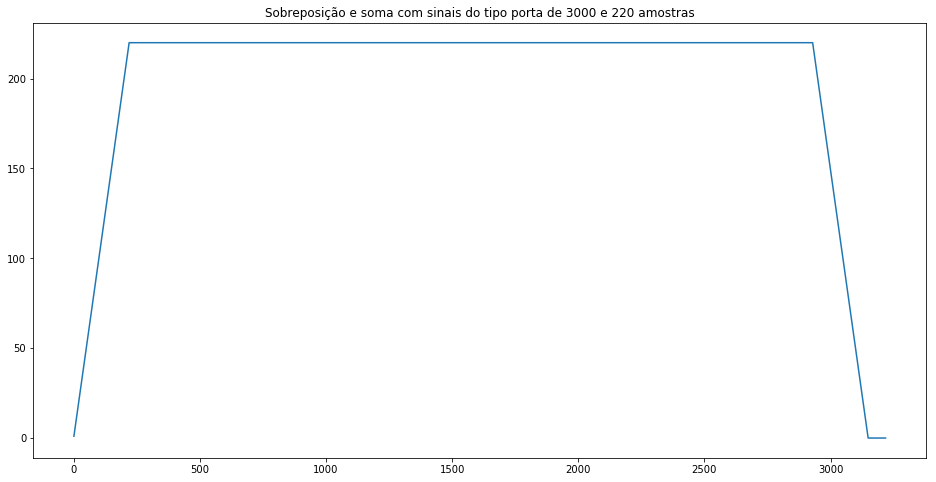

In [97]:
over_and_add = overlap_add(512, signal_port_3000, signal_port_220)

plot(np.absolute(over_and_add), "Sobreposição e soma com sinais do tipo porta de 3000 e 220 amostras")

## Gráfico da convolução utilizando o método Sobreposição e armazenamento

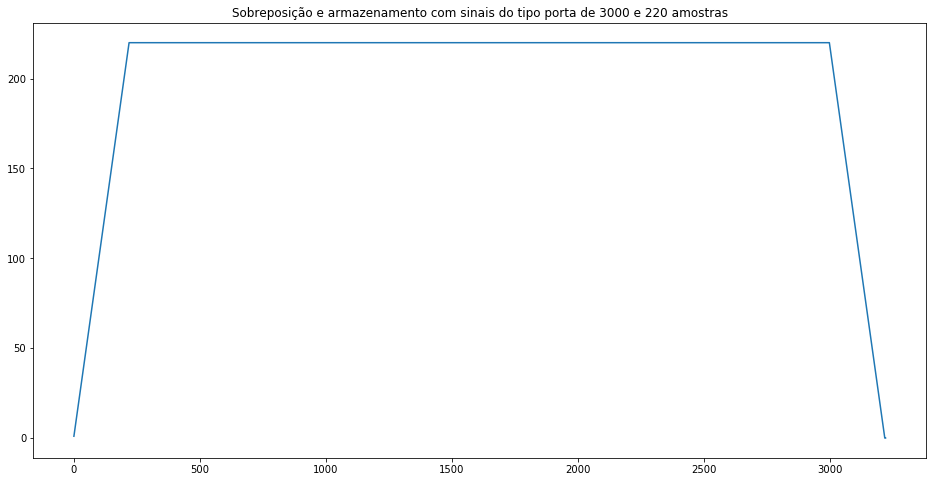

In [95]:
over_and_save = overlap_save(512, signal_port_3000, signal_port_220)

plot(np.absolute(over_and_save), 
     "Sobreposição e armazenamento com sinais do tipo porta de 3000 e 220 amostras")

## Convolução utilizando a função 'convolve' do numpy (Python)

In [15]:
np_conv = np.convolve(signal_port_3000, signal_port_220)

## Gráficos da convolução original do python

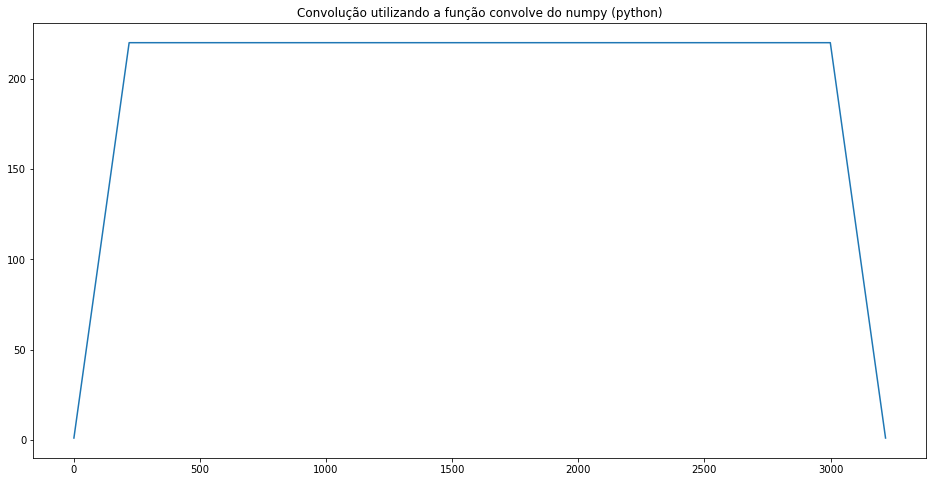

In [16]:
plot(np.absolute(np_conv), 'Convolução utilizando a função convolve do numpy (python)')

# Simulação 2

## Criação do filtro, h[n]

In [17]:
n = np.arange(0,125)
h = ((np.sinc(0.325*(n - 62)))*(0.325))* (0.5 - 0.5*np.cos(2*np.pi*n/124))

## Plot de h[n]

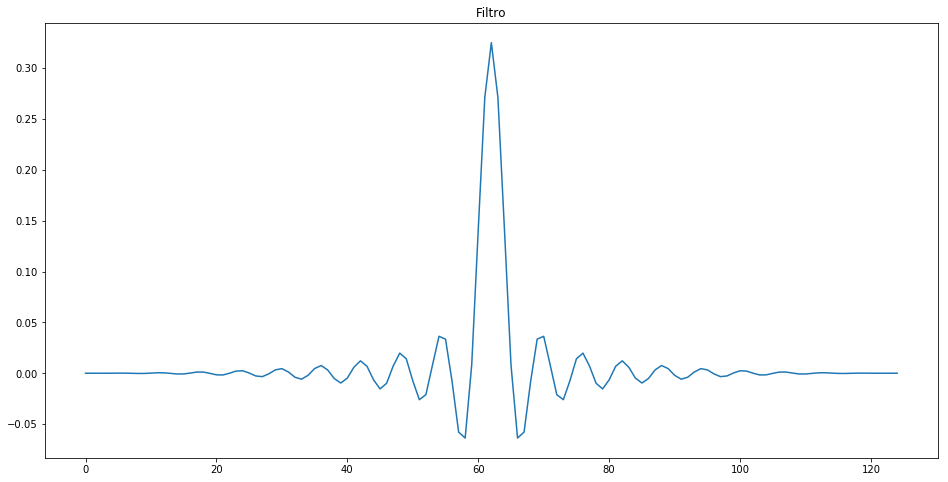

In [30]:
plot(h, "Filtro")

## Plot da fft de h[n]

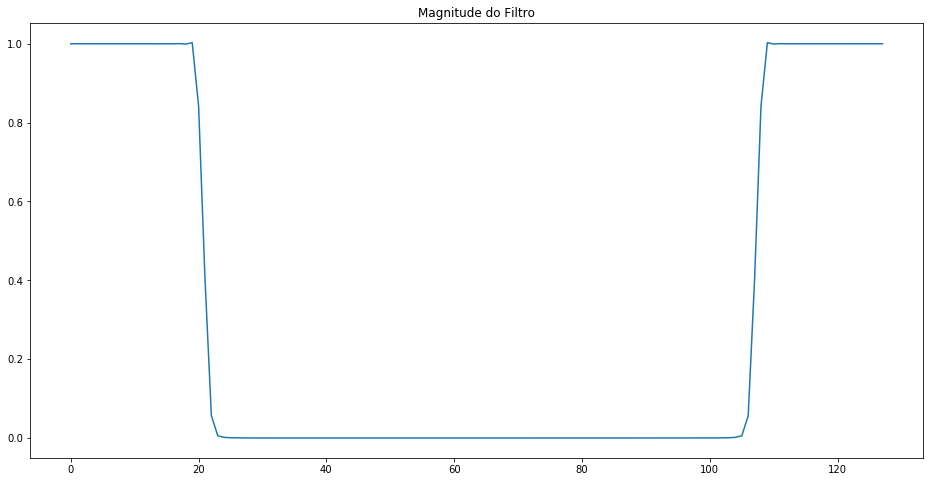

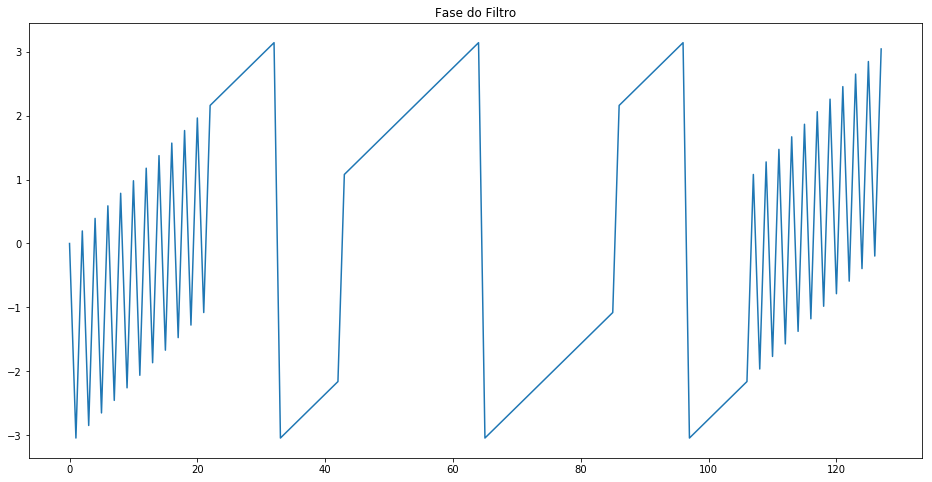

In [39]:
h = complete_zeros(calcular_numero_de_zeros(h), h)
h_jw = fft(1, len(h),h)
plot(np.absolute(h_jw), "Magnitude do Filtro")
plot(np.angle(h_jw), "Fase do Filtro")

## Importação dos arquivos de áudio

In [140]:
fs, data_rute = wavfile.read('voz_de_rute.wav')
fs, data_ruido = wavfile.read('ruido.wav')

## Áudio original

In [141]:
ipd.Audio(data_rute, rate=8000)

/home/rute/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


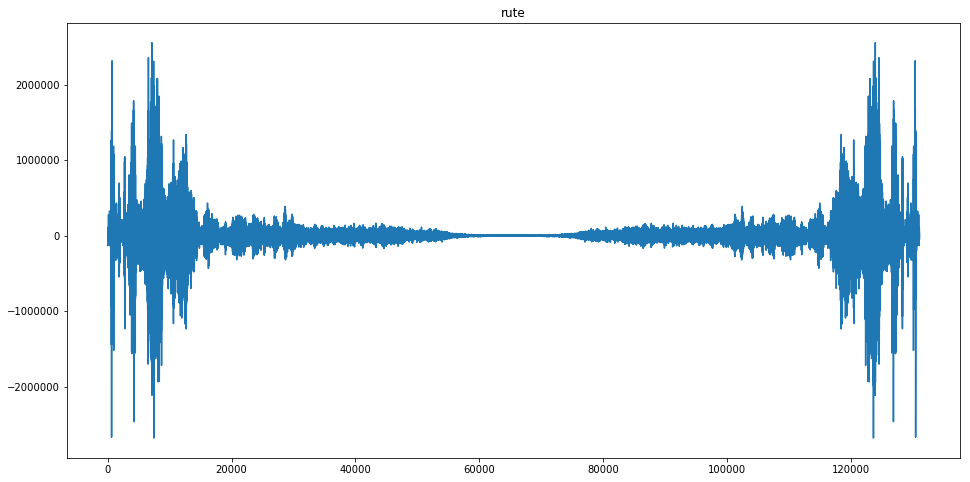

In [142]:
data_rute_add = complete_zeros(calcular_numero_de_zeros(data_rute), data_rute)
plot(fft(1, len(data_rute_add), data_rute_add), 'rute')

## Ruído

In [143]:
ipd.Audio(data_ruido, rate=8000)

### Plot da fft, em fase e magnitude, do ruído

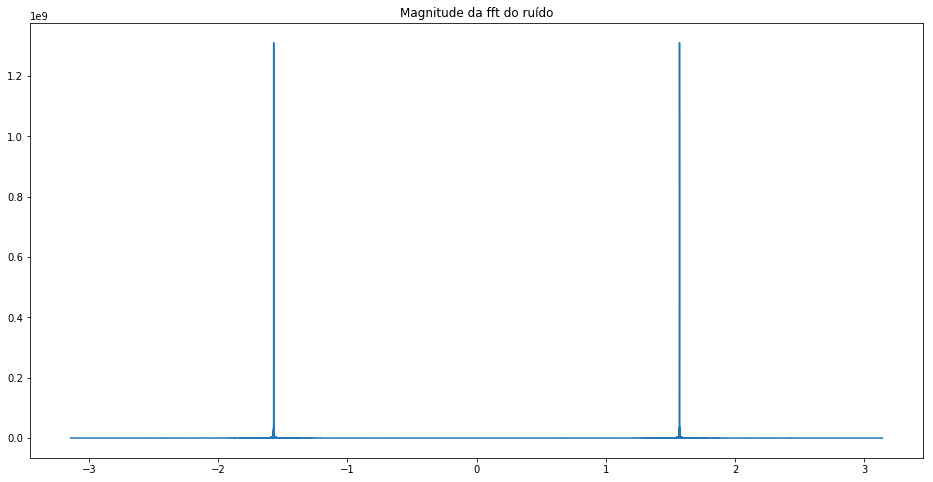

In [310]:
data_ruido_add = complete_zeros(calcular_numero_de_zeros(data_ruido), data_ruido)
y = np.absolute(fft(1, len(data_ruido_add),data_ruido_add))

plot(np.absolute(y), 'Magnitude da fft do ruído', np.linspace(-np.pi,np.pi, len(y)))


## Sinal de voz com adição do ruído

In [145]:
voz_com_ruido = data_rute+0.1*data_ruido
ipd.Audio(voz_com_ruido, rate=8000)

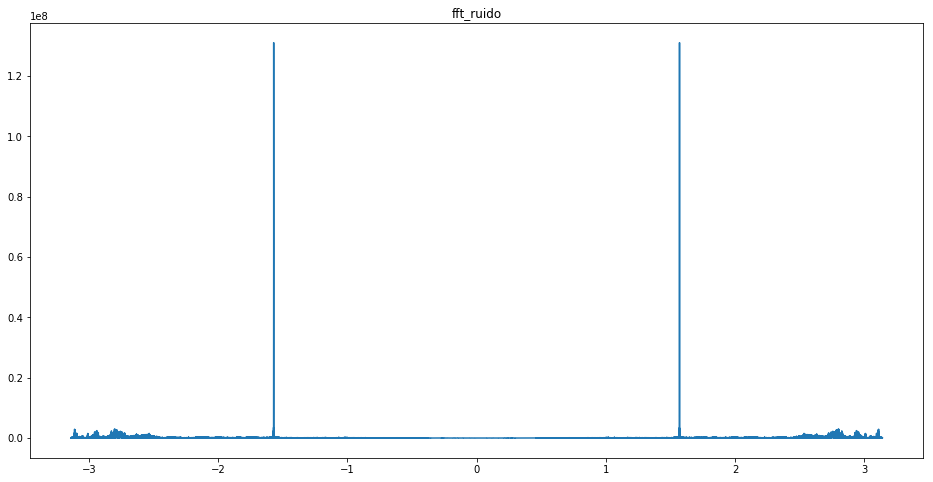

In [312]:
voz_com_ruido_add = complete_zeros(calcular_numero_de_zeros(voz_com_ruido), voz_com_ruido)
x = np.linspace(-np.pi,np.pi, len(voz_com_ruido_add))
plot(np.absolute(fft(1, len(voz_com_ruido_add),voz_com_ruido_add)), 'fft_ruido', x)

## Voz filtrada utilizando o método de Sobreposição e soma

In [22]:
voz_filtrada_over_and_add = overlap_add(512, voz_com_ruido, h)

In [26]:
ipd.Audio(np.real(voz_filtrada_over_and_add), rate=8000)

### Plot da fft, em magnitude e fase, do sinal de voz com ruído adicionado

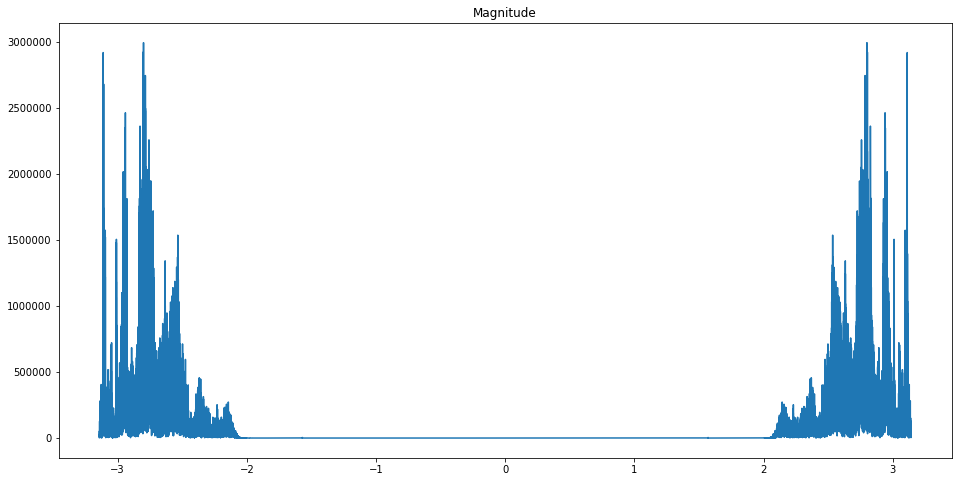

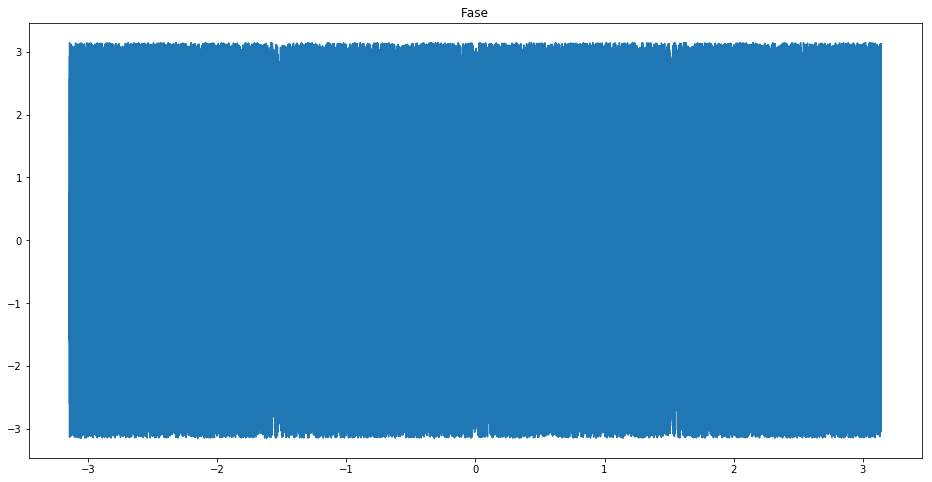

In [318]:
voz_filtrada_add_zero = complete_zeros(calcular_numero_de_zeros(voz_filtrada_over_and_add), voz_filtrada_over_and_add)
x = np.linspace(-np.pi,np.pi, len(voz_filtrada_add_zero))
fft_voz_filtrada_soma = fft(1, len(voz_com_ruido_add),voz_filtrada_add_zero)
plot(np.absolute(fft_voz_filtrada_soma), 'Magnitude', x)
plot(np.angle(fft_voz_filtrada_soma), 'Fase', x)

## Voz filtrada utilizando o método de Sobreposição e armazenamento

In [24]:
voz_filtrada_over_and_save = overlap_save(512, voz_com_ruido, h)

In [28]:
ipd.Audio(np.real(voz_filtrada_over_and_save), rate=8000)

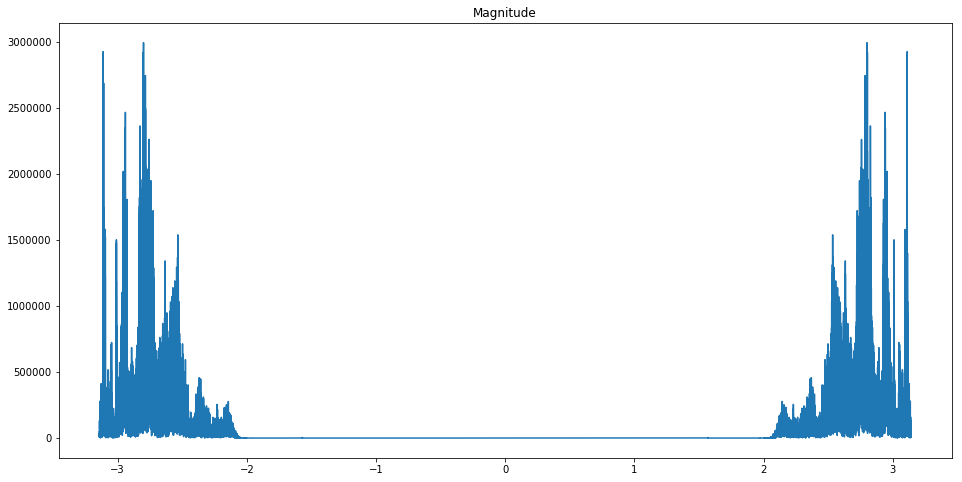

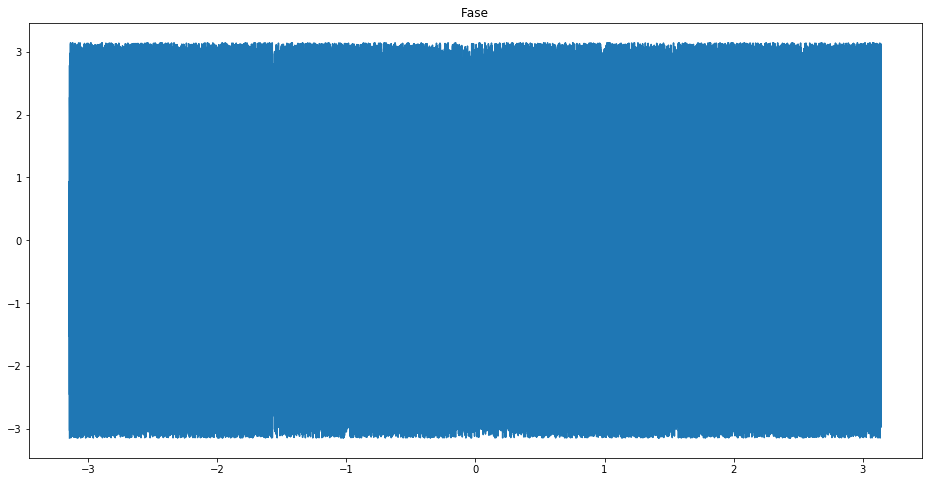

In [326]:
voz_filtrada_over_and_save_add = complete_zeros(calcular_numero_de_zeros(voz_filtrada_over_and_save), voz_filtrada_over_and_save)
voz_filtrada_save_fft = fft(1, len(voz_filtrada_over_and_save_add), voz_filtrada_over_and_save_add)

plot(np.absolute(voz_filtrada_save_fft), 'Magnitude', np.linspace(-np.pi,np.pi, len(voz_filtrada_save_fft)))
plot(np.angle(voz_filtrada_save_fft), 'Fase', np.linspace(-np.pi,np.pi, len(voz_filtrada_save_fft)))

# Simulação 3
    Projeto de filtro rejeita faixa para rejeitar o ruído e 2kHz

In [324]:
wc1 = 1.7*(np.pi*2*1/8)
wc2 = 2.3*(np.pi*2*1/8)
M = 100
n = np.arange(0,M+1)

h_real = np.zeros(M+1)

for i in np.arange(0,len(n)):
    if i != M/2:
        h_real[i] = (1/((i - M/2)*np.pi))*(np.sin(wc1*(i - M/2)) - np.sin(wc2 *(i - M/2)))*(0.5 - 0.5*np.cos(2*np.pi*i/M))
    else:
        h_real[i] =  1 - ((wc2 -wc1)/np.pi)


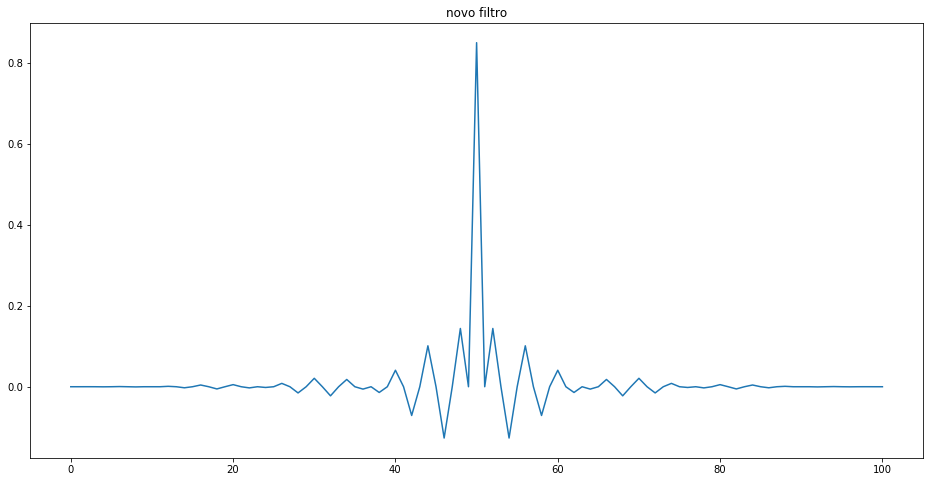

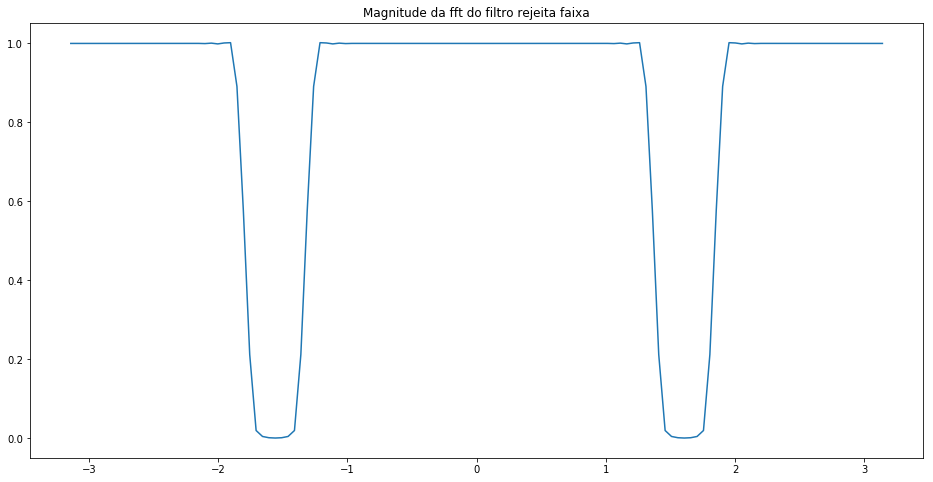

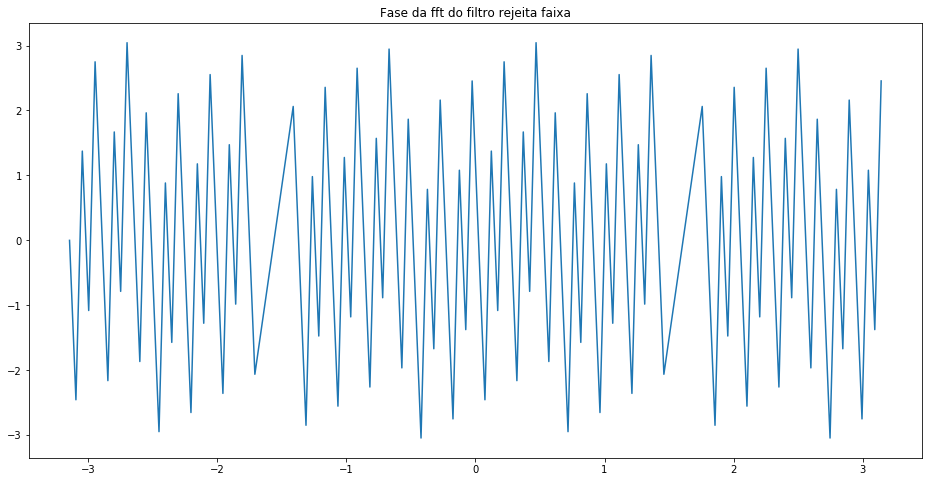

In [327]:
plot(h_real,'novo filtro')

h_real_add = complete_zeros(calcular_numero_de_zeros(h_real), h_real)
h_real_fft = fft(1, len(h_real_add),h_real_add)

plot(np.absolute(h_real_fft), 'Magnitude da fft do filtro rejeita faixa', np.linspace(-np.pi,np.pi, len(h_real_fft)))
plot(np.angle(h_real_fft), 'Fase da fft do filtro rejeita faixa', np.linspace(-np.pi,np.pi, len(h_real_fft)))


## Utilização dos algoritimos: Sobreposição e soma e Sobreposição e armazenamento

### Sobreposição e armazenamento com o novo filtro

In [304]:
novo_filtro = overlap_add(512, voz_com_ruido, h_real)

In [283]:
ipd.Audio(np.real(novo_filtro), rate=8000)

### Plot da fft do sinal, em fase e magnitude, filtrado utilizando o filtro rejeita faixa

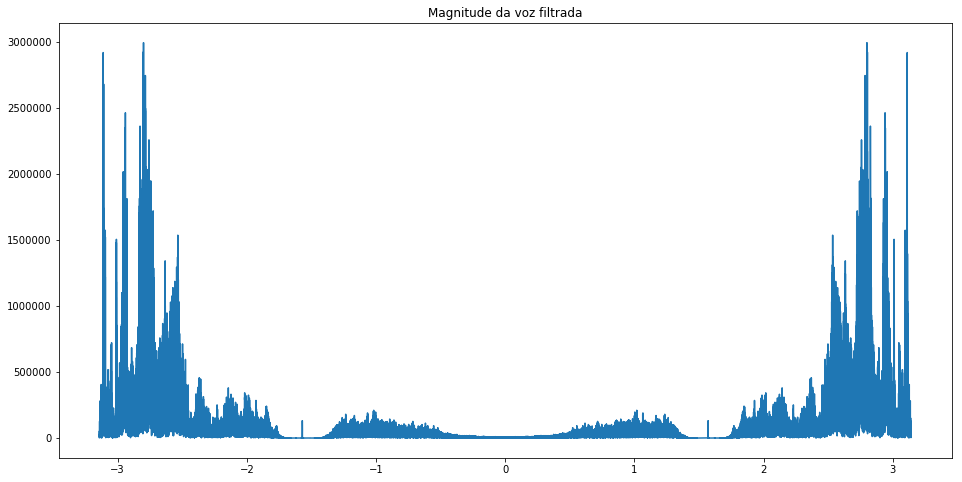

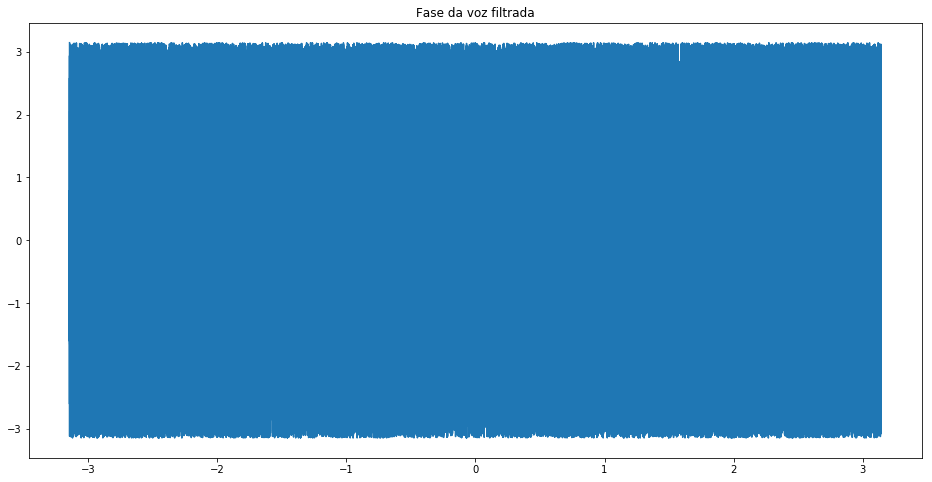

In [329]:
novo_filtro_add = complete_zeros(calcular_numero_de_zeros(novo_filtro), novo_filtro)
voz_filtrada_rf = fft(1, len(novo_filtro_add), novo_filtro_add)

plot(np.absolute(voz_filtrada_rf), 'Magnitude da voz filtrada', np.linspace(-np.pi,np.pi, len(voz_filtrada_rf)))
plot(np.angle(voz_filtrada_rf), 'Fase da voz filtrada', np.linspace(-np.pi,np.pi, len(voz_filtrada_rf)))